# Time Series Analysis_Fransdana Nadeak

Use Case kali ini berhubungan dengan waktu. Dataset yang diberikan adalah dataset penjualan dari tahun 1981 sampai 2005 per 4 kuartal. 
Problem dari use case ini adalah untuk memprediksi berapa penjualan untuk 3 tahun ke depan. Untuk melakukan itu akan dilakukan pemodelan Time Series untuk memprediksi penjualan.
Model Time Series yang akan dicobakan ada 5 model yaitu,
1. Single Exponential Smoothing
2. Double Exponential Smoothing
3. Holt Winter
4. ARIMA
5. SARIMA

Dari ke 5 model tersebut akan dibandingkan MAE (Mean Absolute Eror) nya. MAE terkecil akan dipilih untuk memprediksi dataset penjualan tersebut

# Load Package

In [93]:

import pandas as pd
import numpy as np
import seaborn as sns
import datetime
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
#rcParams['figure.figsize']=10,6
from warnings import filters
from statsmodels.tsa.api import Holt, ARIMA, SARIMAX, SimpleExpSmoothing, ExponentialSmoothing
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import itertools
import statsmodels.api as sm
plt.style.use('fivethirtyeight')
#import pmdarima as pm

# Import data

In [36]:
dataset=pd.read_excel('Exercise1.xlsx')
#Parse strings to datetime type
dataset.head()

,Unnamed: 0,Sales,AdBudget,GDP
0,1981-03-01,1020.2,659.2,251.8
1,1981-06-01,889.2,589.0,290.9
2,1981-09-01,795.0,512.5,290.8
3,1981-12-01,1003.9,614.1,292.4
4,1982-03-01,1057.7,647.2,279.1


Dari dataset diatas, terlihat bahwa data tersebut masih belum layak untuk dimasukkan ke model dikarenakan belum ada unsur datetime nya. oleh karena itu akan dilakukan preparasi data untuk membuat index dataset tersebut menjadi waktu

# Data Preparation

In [37]:
dataset.rename(columns={dataset.columns[0]: 'Time'}, inplace=True)
dataset['Time']=pd.to_datetime(dataset['Time'],infer_datetime_format=True)
dataset=dataset.set_index(dataset.columns[0])
dataset.head()

,Sales,AdBudget,GDP
Time,,,
1981-03-01,1020.2,659.2,251.8
1981-06-01,889.2,589.0,290.9
1981-09-01,795.0,512.5,290.8
1981-12-01,1003.9,614.1,292.4
1982-03-01,1057.7,647.2,279.1


In [38]:
sales=dataset['Sales']

## Train-test Split

In [39]:
train=sales[:79]
test=sales[80:]

Data time series yang sudah bersih, akan dibagi menjadi data train dan data testing, tujuannya adalah untuk melihat evaluasi model tersebut jika ada data dari luar dicobakan

# Single Exponential Smoothing

Single_Explonential_Smoothing atau SES merupakan salah satu model time series sederhana untuk mem-forecast. Model ini biasanya dipakai untuk data yang sudah stasioner dalam ragam dan rataan. Parameter yang digunakan dalam pemulusan datanya adalah alpha. Semakin besar alpha, maka akan semakin mengikuti data historis sebelumnya.

In [40]:
# Simple Exponential Smoothing
alpha=[]
MAE_full=[]
MAE_train=[]
MAE_test=[]
for i in np.arange(0.1,1,0.1):
    fit = SimpleExpSmoothing(sales).fit(smoothing_level=i,optimized=False)
    fit_train=SimpleExpSmoothing(train).fit(smoothing_level=i,optimized=False)
    fcast = fit.forecast(20).rename(r'$\alpha=%s$'%fit.model.params['smoothing_level'])
    alpha.append(i)
    MAE_full.append(mean_absolute_error(fit.fittedvalues,sales))
    MAE_train.append(mean_absolute_error(fit_train.fittedvalues,train))
    MAE_test.append(mean_absolute_error(fcast,test))
SES=pd.DataFrame()
SES['alpha']=alpha
SES['MAE_full']=MAE_full
SES['MAE_train']=MAE_train
SES['MAE_test']=MAE_test
SES['Gap']=SES['MAE_train']-SES['MAE_test']
SES.sort_values('Gap')

,alpha,MAE_full,MAE_train,MAE_test,Gap
0,0.1,85.555345,87.780546,74.049638,13.730908
1,0.2,89.466563,92.530950,73.666064,18.864886
2,0.3,94.779656,98.060062,74.118330,23.941732
3,0.4,100.306707,103.728286,74.693976,29.034310
4,0.5,105.723930,109.364006,75.088105,34.275901
5,0.6,110.696030,114.425293,75.182339,39.242954
6,0.7,115.369775,118.723398,74.914538,43.808860
7,0.8,119.499557,122.623651,74.245445,48.378207
8,0.9,122.345553,125.308967,73.161966,52.147001


Setelah dilakukan looping, terlihat bahwa model SES dengan alpha 0.2 memiliki MAE_test paling kecil dibanding yang lain, namun, nilai tersebut sangat jauh berbeda dengan MAE dari data train nya, sehingga model dengan alpha 0.2 ditakutkan overfit, sehingga, dipilihlah model SES dengan alpha = 0.2

<function matplotlib.pyplot.show>

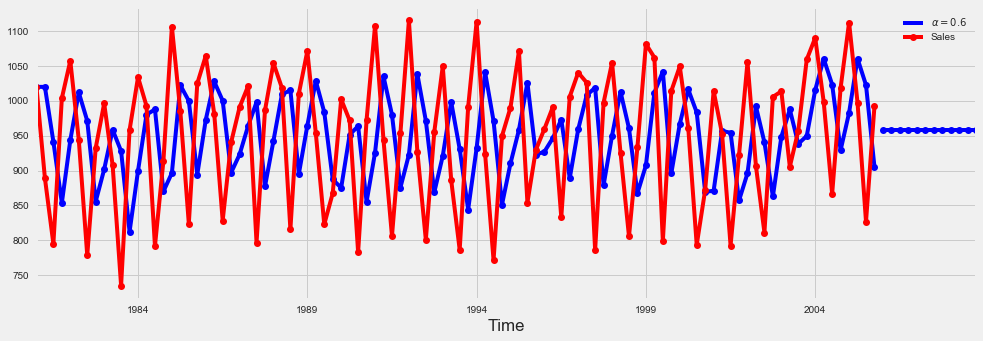

In [41]:
# FIX Simple Exponential Smoothing
plt.figure(figsize=(15,5))
ses = SimpleExpSmoothing(sales).fit(smoothing_level=0.6,optimized=False)
fcast_ses = ses.forecast(12).rename(r'$\alpha=0.6$')
# plot
fcast_ses.plot(marker='o', color='blue', legend=True)
ses.fittedvalues.plot(marker='o',  color='blue')

sales.plot(marker='o', color='red', legend=True)
plt.show

Berikut merupakan hasil Visualisasi dari Model SES dengan data aktual, Warna biru merupakan model SES, sedangkan warna merah merupakan data aktual nya

# Holt-Winters

Model Holt-Winter merupakan model yang sangat digunakan apabila pola dari data historicalnya membentuk pola sesonal. Model ini menggunakan pola trend dan pola seasonal dari data historicalnya untuk forecasting data selanjutnya. Dari Visualisasi sebelumnya, dapat terlihat bahwa data penjualan merupakan data seasonal pertahun selama 4 kuartal. Sehingga, seharusnya model ini bagus digunakan untuk data tersebut

In [42]:
Trend=[]
Seasonal=[]
MAE_full=[]
MAE_train=[]
MAE_test=[]
trend=['add','mul']
seasonal=['add','mul']

for i in trend:
    for j in seasonal:
        fit = ExponentialSmoothing(sales, seasonal_periods=4, trend=i, seasonal=j).fit(use_boxcox=True)
        fit_train=ExponentialSmoothing(train, seasonal_periods=4, trend='add', seasonal='add').fit(use_boxcox=True)
        fcast=fit.forecast(20)
        MAE_full.append(mean_absolute_error(fit.fittedvalues,sales))
        MAE_train.append(mean_absolute_error(fit_train.fittedvalues,train))
        MAE_test.append(mean_absolute_error(fcast,test))
        Trend.append(i)
        Seasonal.append(j)
HW=pd.DataFrame()
HW['Trend']=Trend
HW['Seasonal']=Seasonal
HW['MAE_full']=MAE_full
HW['MAE_train']=MAE_train
HW['MAE_test']=MAE_test
HW['Gap']=np.abs(HW['MAE_train']-HW['MAE_test'])
HW.sort_values('Gap')

,Trend,Seasonal,MAE_full,MAE_train,MAE_test,Gap
0,add,add,38.703390,36.449208,40.257086,3.807878
2,mul,add,38.866635,36.449208,40.506768,4.057560
1,add,mul,37.032046,36.449208,40.783585,4.334377
3,mul,mul,37.416215,36.449208,42.187988,5.738780


Dari hasil looping parameter dari model Holt_winter, terlihat bahwa model Holt-Winter dengan pendefinisian Trend dan Seasonalnya Additive, merupakan model dengan MAE terkecil dengan gap yang paling kecil juga terhadap train dan testnya 

MAE_full 38.70339041864716
MAE_train 36.449208298227894
MAE_test 40.257086186726944


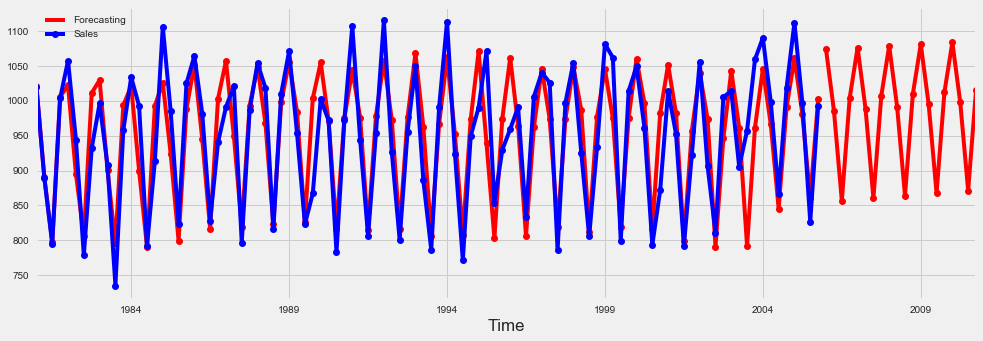

In [43]:
plt.figure(figsize=(15,5))
fit = ExponentialSmoothing(sales, seasonal_periods=4, trend='add', seasonal='add').fit(use_boxcox=True)
fit_train=ExponentialSmoothing(train, seasonal_periods=4, trend='add', seasonal='add').fit(use_boxcox=True)
fcast=fit.forecast(20).rename("Forecasting")

fit.fittedvalues.plot(marker='o', color='red',legend=False)
fcast.plot(marker='o', color='red', legend=True)
sales.plot(marker='o', color='blue', legend=True)

MAE_full=(mean_absolute_error(fit.fittedvalues,sales))
MAE_train=(mean_absolute_error(fit_train.fittedvalues,train))
MAE_test=(mean_absolute_error(fcast,test))
print('MAE_full',MAE_full)
print('MAE_train',MAE_train)
print('MAE_test',MAE_test)

plt.show()

Berikut merupakan hasil visualisasi Data Aktual dengan Data Forecasting dari model Holt Winter. Dan juga sudah ter forecast juga penjualan untuk 3 tahun ke depan, dan menurut saya itu make sense dengan polanya yang seperti itu

# Double Exponential Smoothing

Model Double Exponential Smoothing atau DES merupakan model yang baik digunakan jika datanya membentuk pola trend, baik naik ataupun turun. Parameter yang digunakan dalam model ini adalah alpha dan beta, yg dimana beta adalah 1-alpha

In [44]:
level=[]
slope=[]
MAE_full=[]
MAE_train=[]
MAE_test=[]
for i in np.arange(0.1,1,0.1):
    fit = Holt(sales).fit(smoothing_level=i, smoothing_slope=1-i, optimized=False)
    fit_train=Holt(train).fit(smoothing_level=i, smoothing_slope=1-i, optimized=False)
    fcast = fit.forecast(20).rename("Holt's linear trend")
    MAE_full.append(mean_absolute_error(fit.fittedvalues,sales))
    MAE_train.append(mean_absolute_error(fit_train.fittedvalues,train))
    MAE_test.append(mean_absolute_error(fcast,test))
    level.append(i)
    slope.append(1-i)

H=pd.DataFrame()
H['Smoothing_level']=level
H['Smoothing_slope']=slope
H['MAE_full']=MAE_full
H['MAE_train']=MAE_train
H['MAE_test']=MAE_test
H['Gap']=np.abs(H['MAE_train']-H['MAE_test'])
H.sort_values('Gap')

,Smoothing_level,Smoothing_slope,MAE_full,MAE_train,MAE_test,Gap
6,0.7,0.3,132.288095,135.988750,122.487880,13.500870
5,0.6,0.4,129.680958,133.652352,179.573935,45.921583
7,0.8,0.2,131.849486,135.250407,85.594643,49.655764
0,0.1,0.9,109.195547,115.419262,166.534504,51.115242
8,0.9,0.1,129.174294,132.426659,71.019110,61.407549
4,0.5,0.5,124.581239,128.516223,224.888830,96.372607
3,0.4,0.6,118.161763,122.275677,258.157653,135.881977
2,0.3,0.7,111.479255,115.704299,279.919142,164.214843
1,0.2,0.8,104.826114,109.601577,302.780151,193.178574


Dari hasil looping parameter tersebut, terlihat bahwa parameter yang paling optimal yang memberikan MAE terkecil adalah model DES dengan alpha=0.7 dan beta=0.3

MAE_full 130.61331307250921
MAE_train 132.42665894008053
MAE_test 72.9035864415807


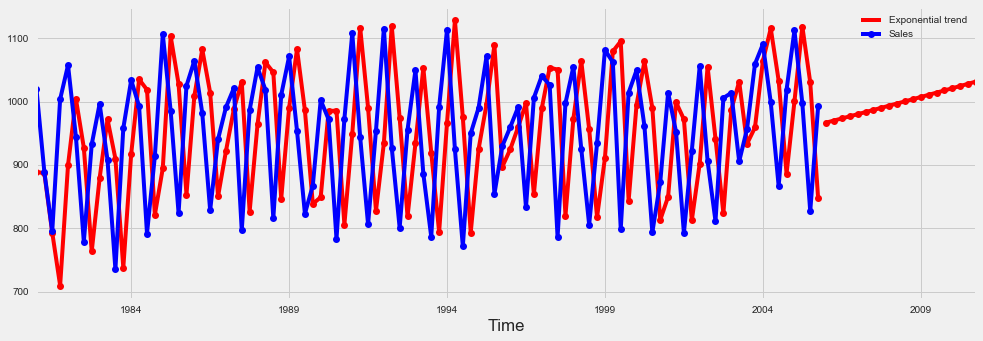

In [45]:
plt.figure(figsize=(15,5))
#fit = Holt(sales).fit(smoothing_level=0.7, smoothing_slope=0.3, optimized=False)
#fcast = fit.forecast(20).rename("Holt's linear trend")

fit = Holt(sales, exponential=True).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
fcast = fit.forecast(20).rename("Exponential trend")

#fit = Holt(sales, damped=True).fit(smoothing_level=0.8, smoothing_slope=0.2)
#fcast = fit.forecast(20).rename("Additive damped trend")


fit.fittedvalues.plot(marker="o", color='red')
fcast.plot(color='red', marker="o", legend=True)
#fit2.fittedvalues.plot(marker="o", color='red')
#fcast2.plot(color='red', marker="o", legend=True)
#fit3.fittedvalues.plot(marker="o", color='green')
#fcast3.plot(color='green', marker="o", legend=True)
sales.plot(marker='o', color='blue', legend=True)
MAE_full=(mean_absolute_error(fit.fittedvalues,sales))
MAE_train=(mean_absolute_error(fit_train.fittedvalues,train))
MAE_test=(mean_absolute_error(fcast,test))
print('MAE_full',MAE_full)
print('MAE_train',MAE_train)
print('MAE_test',MAE_test)
plt.show()

Berikut merupakan hasil visualisasi dan forecasting dari data penjualan. Terlihat sekali bahwa hasil forecastingnya tidak mencerminkan pola data sebelumnya, itu dikarenakan memang karena fungsi dari model eksponensial ini tidak digunakan untuk data yang seasonal

# ARIMA

ARIMA merupakan salah satu model time series yang paling sering digunakan kebanyakan orang pada saat ini. Model ARIMA merupakan model parametrik yang berarti sangat sensitive dengan asumsi dan salah satu syarat yang harus dipenuhi adalah data itu harus sudah stasioner dalam ragam dan rataan. Parameter dari ARIMA adalah p,d, dan q.

## Exploratory Data Analysis

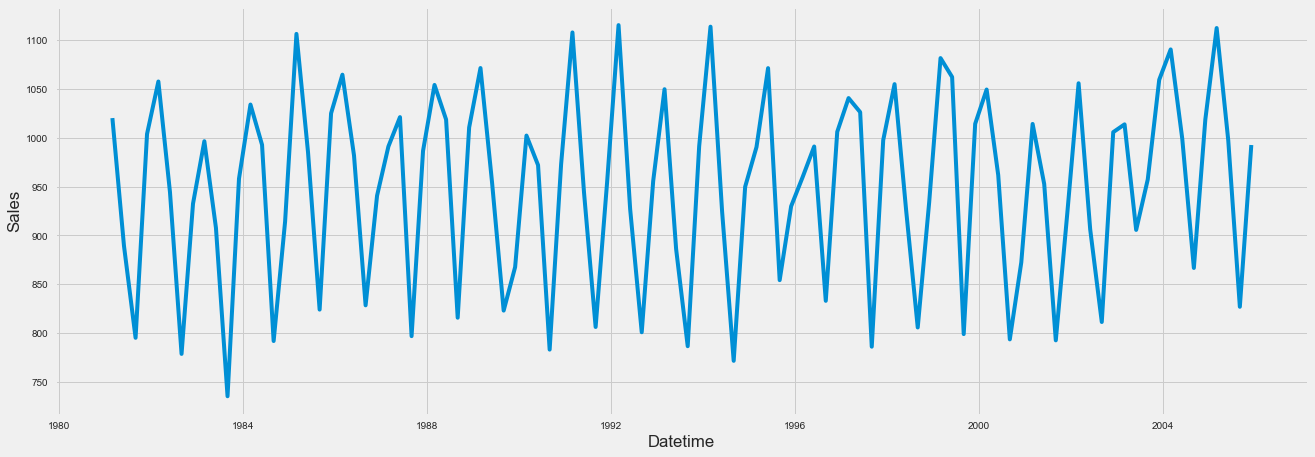

In [87]:
plt.figure(figsize=(20,7))
ax=plt.gca()
ax.set_xlabel('Datetime')
ax.set_ylabel('Sales')
plt.plot(sales);

Dari Visualisasi data di atas, terlihat bahwwa data penjualan tersebut terlihat sudah stasioner dalam rataan dan ragam. Dari grafik itu juga, terlihat bahwa data ini memiliki pola seasonal tiap tahunnya

# Forecasting

Given this data is a timeseries with a decent amount of past values, let's use an ARIMA model for fitting and forecasting efforts. Unfortunately, I did not find the weather variable very useful and the cloud indicator simply helped throw out faulty data. The only other information is the time component, which will be used in the ARIMA model.

<br>
To use ARIMA, I need to first ensure the data is stationary (time, variance, co-variance should not be dependent on time). I'll use the Dickey-Fuller Test Statitic (which statsmodel library includes already).

In [88]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12,center=False).mean()
    rolstd = timeseries.rolling(window=12,center=False).std()
    
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput) 

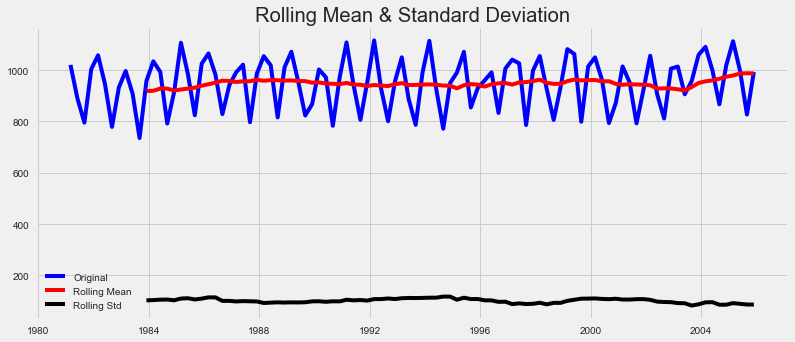

Results of Dickey-Fuller Test:
Test Statistic                 -3.262755
p-value                         0.016628
#Lags Used                      9.000000
Number of Observations Used    90.000000
Critical Value (1%)            -3.505190
Critical Value (5%)            -2.894232
Critical Value (10%)           -2.584210
dtype: float64


In [89]:
test_stationarity(sales)

Di atas merupakan cara untuk melihat dan menguji apakah data tersebut sudah stasioner atau belum. Dari grafik, terlihat bahwa datanya sudah stasioner. Untuk memperkuat hipotesa kita, akan diuji secara statistik apakah data itu sudah stasioner atau belum

Uji untuk kestasioneran data adalah Uji ADF atau ADF test
1. H0 : Data Tidak Stasioner
2. H1 : Data Stasioner

Jika P-Value dari adf test berikut lebih kecil dari 0.05, maka Tolak H0, yang berarti Data sudah stasioner. Dan sudah terlihat di atas bahwa p-value nya sebesar 0.0166 dan sudah lebih kecil dari 0.05

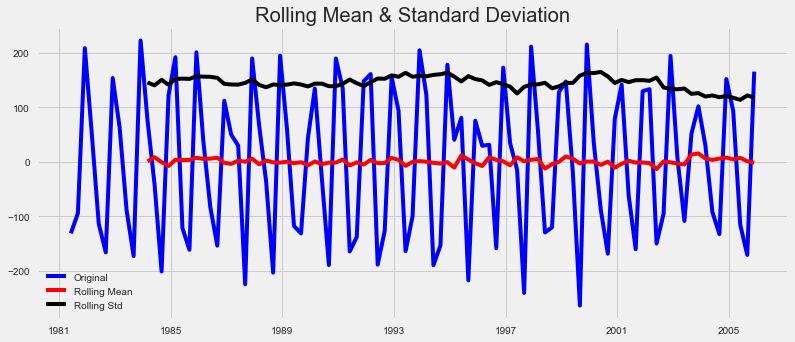

Results of Dickey-Fuller Test:
Test Statistic                 -5.100287
p-value                         0.000014
#Lags Used                     10.000000
Number of Observations Used    88.000000
Critical Value (1%)            -3.506944
Critical Value (5%)            -2.894990
Critical Value (10%)           -2.584615
dtype: float64


In [90]:
sales_diff1=sales-sales.shift(1)
test_stationarity(sales_diff1.dropna(inplace=False))

# ACF and PACF Graphs

Plot ACF dan PACF digunakan untuk menetukan parameter p dan q untuk model arima

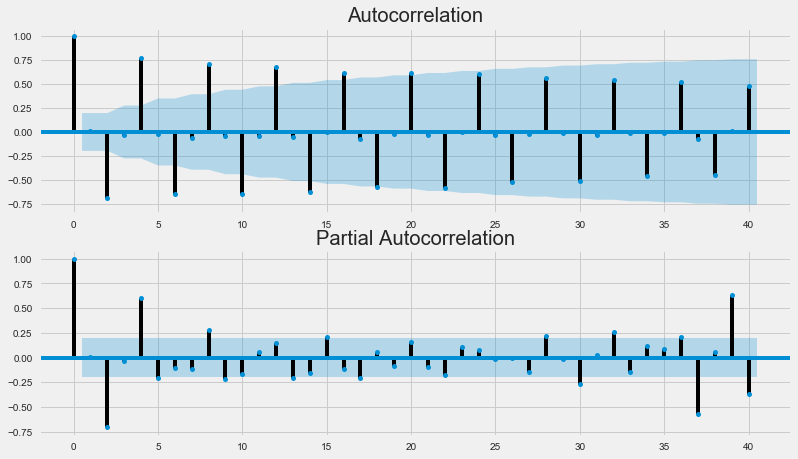

In [91]:
# ACF, PACF graphs to help determine order of ARIMA model, again statsmodel has these handy functions built-in
fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sales[1:], lags=40, ax=ax1)   # first value of diff is NaN
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sales[1:], lags=40, ax=ax2)

Dari plot di atas, terlihat bahwa plot ACF dan PACF nya seperti membentuk, yang memang khusus utk data yang seasonal. Cut Off dari ACF ada di 1, begitupun juga dengan PACF nya. Sehingga didapat bahwa p dan q nya bernilai 1 

MSE =  41.509043553848244


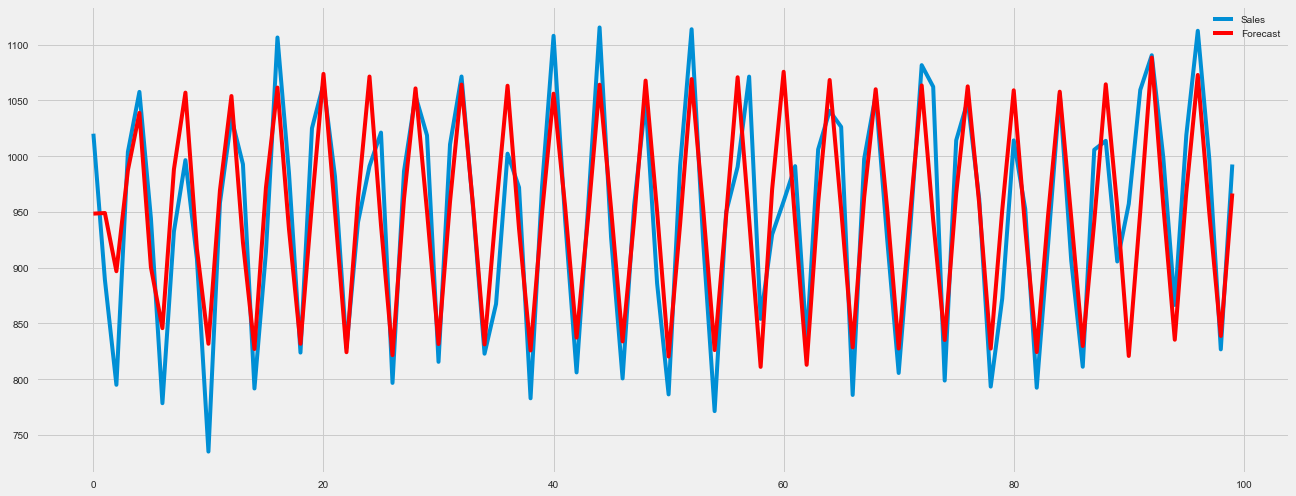

                           Results: ARMA
Model:              ARMA             BIC:                 1106.8783
Dependent Variable: y                Log-Likelihood:      -535.02  
Date:               2019-09-06 05:57 Scale:               1.0000   
No. Observations:   100              Method:              css-mle  
Df Model:           7                Sample:              0        
Df Residuals:       93                                    0        
Converged:          1.0000           S.D. of innovations: 48.308   
No. Iterations:     81.0000          HQIC:                1094.472 
AIC:                1086.0369                                      
--------------------------------------------------------------------
            Coef.    Std.Err.      t      P>|t|    [0.025    0.975] 
--------------------------------------------------------------------
const      948.5116    5.8752   161.4437  0.0000  936.9964  960.0267
ar.L1.y      0.0054    0.1330     0.0406  0.9677   -0.2553    0.2660
ar

In [94]:
# fit ARIMA model
fig = plt.figure(figsize=(20,8))
model = ARIMA(sales.values, order=(4,0,2)) 
ax = plt.gca()
results = model.fit() 
plt.plot(sales.values)
plt.plot(results.fittedvalues, color='red')
ax.legend(['Sales', 'Forecast'])
MSE=mean_absolute_error(sales,results.fittedvalues)
print('MSE = ',MSE) 
plt.show()
print(results.summary2())


Berikut merupakan hasil Visualisasi dan Forecasting dari Model ARIMA. Terlihat bahwa dari visualisasi, model sudah sangat bagus merepresentasikan data historical sebelumnya

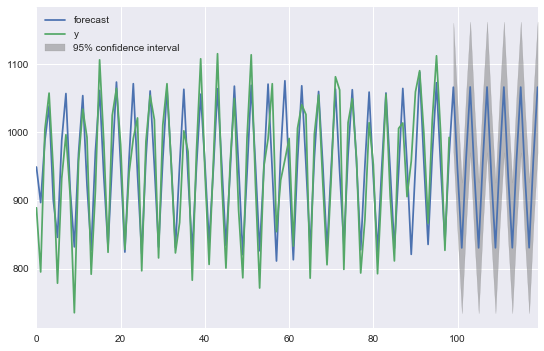

In [95]:
plt.style.use('seaborn')
results.plot_predict(1,120,plot_insample=True)
x=results.forecast(steps=120)


Hasil Forecast 3 periode ke depan dengan ARIMA

# SARIMA

SARIMA hampir sama dengan ARIMA, namun yang membedakan adalah SARIMA khusus digunakan untuk data yang seasonal

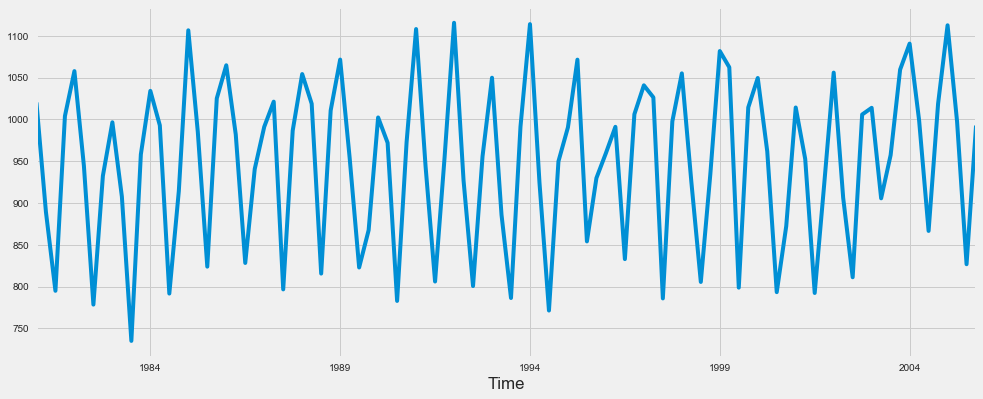

In [54]:
sales.plot(figsize=(15, 6))
plt.show()

In [55]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 4) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA…')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA…
SARIMAX: (0, 0, 1) x (0, 0, 1, 4)
SARIMAX: (0, 0, 1) x (0, 1, 0, 4)
SARIMAX: (0, 1, 0) x (0, 1, 1, 4)
SARIMAX: (0, 1, 0) x (1, 0, 0, 4)


In [79]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(sales,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}4 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 4)4 - AIC:1641.1673227026513
ARIMA(0, 0, 0)x(0, 0, 1, 4)4 - AIC:1461.5115045045036
ARIMA(0, 0, 0)x(0, 1, 0, 4)4 - AIC:1052.130936539117
ARIMA(0, 0, 0)x(0, 1, 1, 4)4 - AIC:971.0840070955201
ARIMA(0, 0, 0)x(1, 0, 0, 4)4 - AIC:1064.5583471421446
ARIMA(0, 0, 0)x(1, 0, 1, 4)4 - AIC:1012.9762933414304
ARIMA(0, 0, 0)x(1, 1, 0, 4)4 - AIC:1004.1960246573165
ARIMA(0, 0, 0)x(1, 1, 1, 4)4 - AIC:970.6835877043917
ARIMA(0, 0, 1)x(0, 0, 0, 4)4 - AIC:1514.9897489142215
ARIMA(0, 0, 1)x(0, 0, 1, 4)4 - AIC:1345.3740915547787
ARIMA(0, 0, 1)x(0, 1, 0, 4)4 - AIC:1040.8954321089407
ARIMA(0, 0, 1)x(0, 1, 1, 4)4 - AIC:958.3854724455542
ARIMA(0, 0, 1)x(1, 0, 0, 4)4 - AIC:1067.5883562908155
ARIMA(0, 0, 1)x(1, 0, 1, 4)4 - AIC:1047.9734929990482
ARIMA(0, 0, 1)x(1, 1, 0, 4)4 - AIC:1002.9373204072438
ARIMA(0, 0, 1)x(1, 1, 1, 4)4 - AIC:959.5291379192065
ARIMA(0, 1, 0)x(0, 0, 0, 4)4 - AIC:1246.6998057861383
ARIMA(0, 1, 0)x(0, 0, 1, 4)4 - AIC:1145.7106176225402
ARIMA(0, 1, 0)x(0, 1, 0, 4)4 - AI

In [57]:
mod = sm.tsa.statespace.SARIMAX(sales,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 4),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1525      0.119      1.277      0.202      -0.082       0.387
ma.L1         -1.0000    247.934     -0.004      0.997    -486.943     484.943
ar.S.L4        0.0107      0.079      0.136      0.892      -0.144       0.165
ma.S.L4       -1.0000    247.894     -0.004      0.997    -486.864     484.864
sigma2      2063.7086      0.092   2.23e+04      0.000    2063.527    2063.890


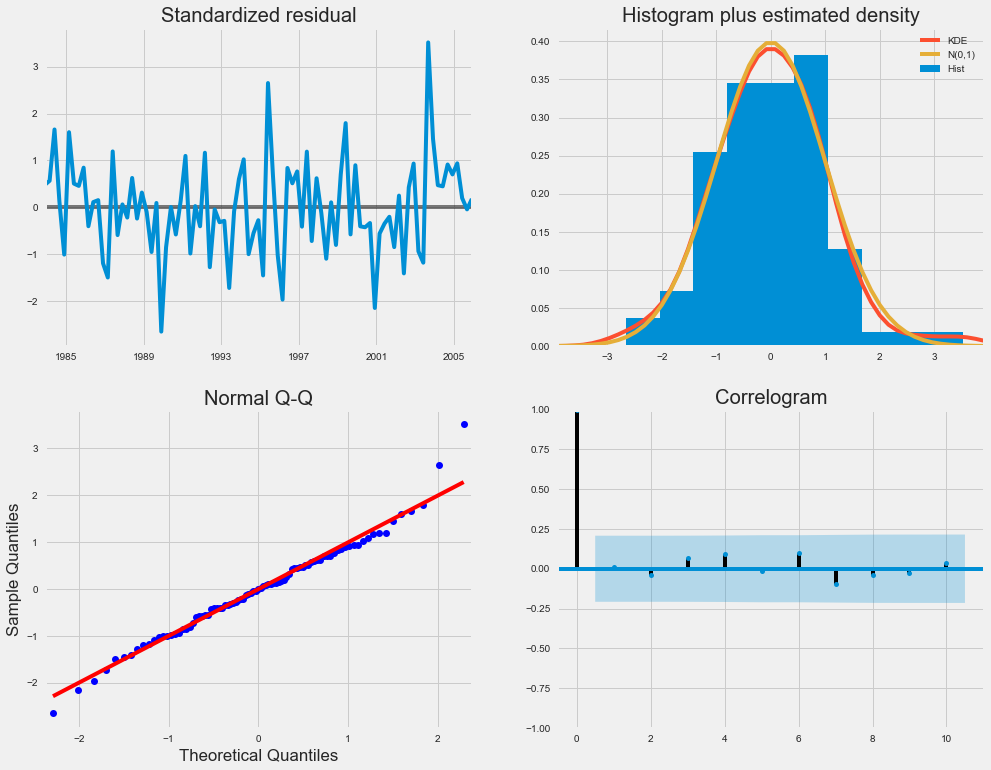

In [58]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

Dari plot residual di atas, terlihat bahwa residual nya sudah menyebar normal, saling acak dan tidak ada autokorelasi sehingga dapat dikatakan, model SARIMA kita sudah memenuhi asumsi dan siap digunakan

In [59]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=12)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

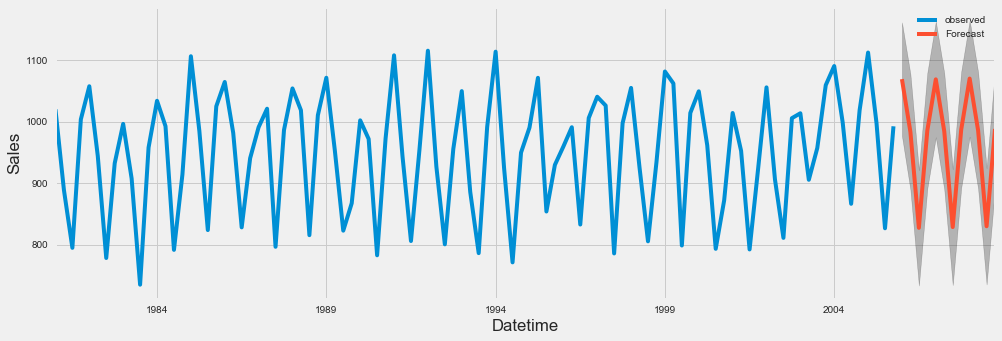

In [60]:
ax = sales.plot(label='observed', figsize=(15, 5))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Datetime')
ax.set_ylabel('Sales')

plt.legend()
plt.show()

Berikut merupakan hasil Visualisasi dan Forecasting dari Model SARIMA

In [83]:
SARIMA=mean_absolute_error(sales[1:],results.predict()[1:])
SARIMA
Single_Exponential_Smoothing=SES['MAE_full'][0]
Single_Exponential_Smoothing
Holt_Winter=HW['MAE_full'][0]
Holt_Winter
Double_Exponential_Smoothing=H['MAE_full'][0]
Double_Exponential_Smoothing
ARIMA=MSE
ARIMA

41.509043553848244

In [85]:
TS_Model=['SARIMA','ARIMA','Single_Exponential_Smoothing','Double_Exponential_Smoothing','Holt_Winter']
MAE=[SARIMA, ARIMA, Single_Exponential_Smoothing, Double_Exponential_Smoothing, Holt_Winter]
Desc=['(1, 1, 1)x(1, 1, 1, 4)4','(4,0,2)','alpha = 0.6','a=0.3 b=0.7','trend=add, seasonal=add']
ModelCompare=pd.DataFrame()
ModelCompare['Time_Series_Model']=TS_Model
ModelCompare['Desc']=Desc
ModelCompare['MAE']=MAE
ModelCompare.sort_values('MAE')


,Time_Series_Model,Desc,MAE
4,Holt_Winter,"trend=add, seasonal=add",38.703390
1,ARIMA,"(4,0,2)",41.509044
0,SARIMA,"(1, 1, 1)x(1, 1, 1, 4)4",48.993933
2,Single_Exponential_Smoothing,alpha = 0.6,85.555345
3,Double_Exponential_Smoothing,a=0.3 b=0.7,109.195547


Setelah menjalankan ke 5 model tersebut, lalu dibandingkan MAE nya, ternyata model Holt-Winter (yang memang khusus digunakan untuk data seasonal) merupakan model terbaik dengan MAE terkecil. Sehingga, kita akan akan menggunakan model ini untuk memprediksi Data Penjualan tersebut.

# Terimakasih